# Notebook 7. Client Reliability.

In [1]:
from typing import Union
from typing import Any
from typing import List
from typing import Set
from typing import Dict
from typing import Tuple
from typing import Optional
from typing import Callable

import pickle
import os
import copy
from collections import OrderedDict
from collections import defaultdict

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline
RANDOM_SEED: int = 42
np.random.seed(RANDOM_SEED)
EstimatorType: Union = Union[sk.base.BaseEstimator, Any]

In [2]:
class DataTable: pass
all_table: DataTable = joblib.load("prepared_data/all_data_dropped_na.jbl")

if not os.path.exists("images/reliability"):
    os.makedirs("images/reliability")

In [3]:
matrix: pd.DataFrame = all_table.matrix

overpaid_contracts: List[str] = list()
underpaid_contracts: List[str] = list()

key: str; df: pd.DataFrame
for key, df in matrix.groupby('CONTRACT_ID'):
    df_copy: pd.DataFrame = copy.deepcopy(df)[
        ['CONTRACT_ID', 'CUMSUM_REPAYMENT_ACTUAL', 'CUMSUM_REPAYMENT_SCHEDULED', 'REPAYMENT_ACTUAL']]
    df_copy['CUMSUM_REPAYMENT_ACTUAL'] += df_copy['REPAYMENT_ACTUAL']
    df_copy = df_copy.drop('REPAYMENT_ACTUAL', axis=1)
    underpay: bool = False
        
    index: int; row: Dict[str, Any]
    for index, row in df_copy.iterrows():
        if not np.isnan(row['CUMSUM_REPAYMENT_ACTUAL']) and row['CUMSUM_REPAYMENT_ACTUAL'] < row['CUMSUM_REPAYMENT_SCHEDULED']:
            underpay: bool = True
    if underpay:
        underpaid_contracts.append(key)
    else:
        overpaid_contracts.append(key)

print("len underpaid = ", len(underpaid_contracts))
print("len overpaid = ", len(overpaid_contracts))

len underpaid =  444
len overpaid =  3348


In [4]:
data_static: pd.DataFrame = pd.read_csv('raw_data/Static.csv', sep=';').drop('CLIENT_ID', axis=1)
data_static['UNDERPAID'] = 0
data_static['UNDERPAID'][data_static['CONTRACT_ID'].isin(underpaid_contracts)] = 1
data_static['GENDER'] = 1 * (data_static['GENDER'] == 'M')

C:\Users\nekrald\AppData\Local\Temp\ipykernel_16868\313034080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_static['UNDERPAID'][data_static['CONTRACT_ID'].isin(underpaid_contracts)] = 1


# Metrics

In [5]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report

def compute_metrics(y_pred: Union[List[int], np.array], 
                    y_true: Union[List[int], np.array]) -> Dict[str, Any]:
    """ Computes classification report.
    
    Arguments:
        y_pred -- Predicted classes.
        y_true -- Reference classes.
        
    Returns:
        Dictionary with classification report.
    """
    scores: Dict[str, Any] = classification_report(
        y_true, y_pred, output_dict=True)
    return scores
    

In [6]:
class TableBuilder:
    """ Entity to store metrics for different classification approaches.
    
    Attributes:
        column2list -- Storage of metrics and algorithm names to be converted
            to Pandas DF afterwards.
    """
    def __init__(self) -> None:
        """ Initialization method. """
        self.column2list: Dict[str, List[Any]] = defaultdict(list)
        
    def commit(self, algo: str, report: Dict[str, Any]) -> None:
        """ Adds classification report to the structure.
        
        Arguments:
            algo -- Name of the algorithm.
            report -- Classification report for the algorithm.
        """
        self.column2list['algorithm'].append(algo)
        self.column2list['accuracy'].append(report['accuracy'])
        self.column2list['precision'].append(report['weighted avg']['precision'])
        self.column2list['recall'].append(report['weighted avg']['recall'])
        self.column2list['f1-score'].append(report['weighted avg']['f1-score'])
        self.column2list['rel. prec.'].append(report['1.0']['precision'])
        self.column2list['rel. rec.'].append(report['1.0']['recall'])
        self.column2list['unrel. prec.'].append(report['0.0']['precision'])
        self.column2list['unrel. rec.'].append(report['0.0']['precision'])
        
    def make_table(self) -> pd.DataFrame:
        """ Method to export the state to pandas table. 
        
        Returns:
            Pandas dataframe with state information.
        """
        return pd.DataFrame.from_dict(self.column2list)

In [7]:
table_builder: TableBuilder = TableBuilder()

# With Logistic Regression

In [8]:
from sklearn.model_selection import train_test_split

y_all: Union[np.array, List[float]] = 1. - np.array(data_static['UNDERPAID'])
clean_df: pd.DataFrame = data_static.drop(['UNDERPAID', 'CONTRACT_ID'], axis=1)
X_all: Union[np.array, List[List[float]]] = np.array(clean_df)

X_train: Union[np.array, List[List[float]]]; y_train: Union[np.array, List[float]]
X_test: Union[np.array, List[List[float]]]; y_test: Union[np.array, List[float]]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.4, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr: EstimatorType = LogisticRegression(n_jobs=-1)

lr_params: Dict[str, List[Any]] = {
    'penalty' : [ 'l2', 'none'],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'class_weight': ['balanced'],
}

grid_lr: EstimatorType = GridSearchCV(lr, lr_params, cv=3)
grid_lr.fit(X_train, y_train)
lr_est: EstimatorType = grid_lr.best_estimator_
y_pred_lr: Union[np.array, List[int]] = grid_lr.predict(X_test)

C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `p

Classification report.

In [10]:
lr_metrics: Dict[str, Any] = compute_metrics(y_pred_lr, y_test)
table_builder.commit("Logistic Regression", lr_metrics)
print(lr_metrics)

{'0.0': {'precision': 0.15857142857142856, 'recall': 0.6, 'f1-score': 0.25084745762711863, 'support': 185.0}, '1.0': {'precision': 0.9094247246022031, 'recall': 0.5578078078078078, 'f1-score': 0.6914844113541182, 'support': 1332.0}, 'accuracy': 0.5629531970995386, 'macro avg': {'precision': 0.5339980765868159, 'recall': 0.5789039039039039, 'f1-score': 0.4711659344906184, 'support': 1517.0}, 'weighted avg': {'precision': 0.8178572494764988, 'recall': 0.5629531970995386, 'f1-score': 0.6377481974849719, 'support': 1517.0}}


In [11]:
lr_est.fit(X_all, y_all)

C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1, penalty='none')

Visualization of LR coefficients.

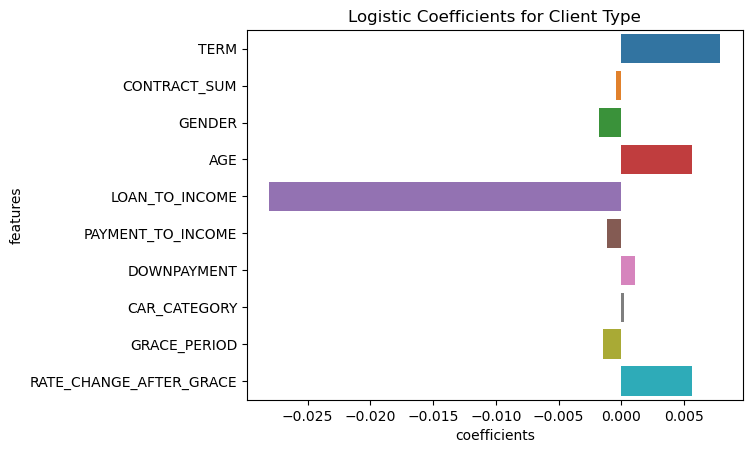

In [13]:
import seaborn as sns

visual_lr: pd.DataFrame = pd.DataFrame()
visual_lr['coefficients'] = np.array(lr_est.coef_)[0]
visual_lr['features'] = clean_df.columns

sns.barplot(x='coefficients', y='features', data=visual_lr)
plt.title("Logistic Coefficients for Client Type")
plt.savefig("images/reliability/lr_reliability.png", dpi=300, bbox_inches='tight')

# With Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_params: Dict[str, List[Any]] = {
    'max_depth': [5, 10],
    'min_samples_leaf': [ 10, 15, 20],
    'max_samples': [0.6, None],
    'n_estimators': [400],
    'class_weight': ['balanced_subsample'],
    'n_jobs': [-1]
}

rf_clf: EstimatorType = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample')

grid_rf: EstimatorType = GridSearchCV(rf_clf, rf_params)
grid_rf.fit(X_train, y_train)
y_pred_rf: Union[List[int], np.array] = grid_rf.predict(X_test)

Classification report.

In [15]:
rf_metrics: Dict[str, Any] = compute_metrics(y_pred_rf, y_test)
table_builder.commit("Random Forest", rf_metrics)
print(rf_metrics)

{'0.0': {'precision': 0.21428571428571427, 'recall': 0.22702702702702704, 'f1-score': 0.2204724409448819, 'support': 185.0}, '1.0': {'precision': 0.8917486752460257, 'recall': 0.8843843843843844, 'f1-score': 0.8880512627214474, 'support': 1332.0}, 'accuracy': 0.8042188529993408, 'macro avg': {'precision': 0.55301719476587, 'recall': 0.5557057057057058, 'f1-score': 0.5542618518331647, 'support': 1517.0}, 'weighted avg': {'precision': 0.809131240982573, 'recall': 0.8042188529993408, 'f1-score': 0.8066392112852809, 'support': 1517.0}}


Visualization of feature importances.

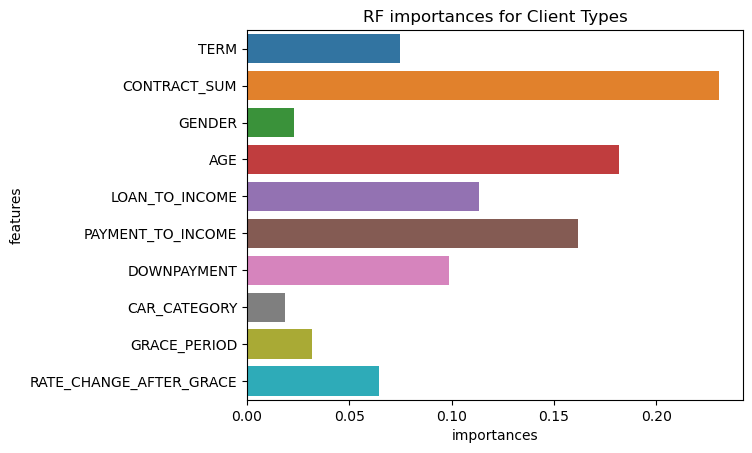

In [16]:
rf_clf: EstimatorType = grid_rf.best_estimator_
rf_clf.fit(X_all, y_all)
importances: Union[np.array, List[float]] = rf_clf.feature_importances_

visual_df: pd.DataFrame = pd.DataFrame()
visual_df['importances'] = importances
visual_df['features'] = clean_df.columns
sns.barplot(x='importances', y='features', data=visual_df)

plt.title("RF importances for Client Types")
plt.savefig("images/reliability/rf_reliability.png", dpi=300, bbox_inches='tight')

# Performance Comparison

Results are exported to `tables` directory.

In [17]:
table: pd.DataFrame = table_builder.make_table()
table.to_excel("tables/reliability.xlsx")
table.to_latex("tables/reliability.tex", float_format="%.2f")
table

,algorithm,accuracy,precision,recall,f1-score,rel. prec.,rel. rec.,unrel. prec.,unrel. rec.
0,Logistic Regression,0.562953,0.817857,0.562953,0.637748,0.909425,0.557808,0.158571,0.158571
1,Random Forest,0.804219,0.809131,0.804219,0.806639,0.891749,0.884384,0.214286,0.214286
